## Loading the Data

In [1]:
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import zipfile
import os
from torch.utils.data import ConcatDataset

# Extra info for logging
extra = 'change to freeze all layers + dropout 0.5 + unfreeze batchnorm + cropped images + track both best val_loss and val_acc + add original image + test image not cropped + add augmented_more dataset + no crop augmented data'

# Load the metadata
metadata = pd.read_csv('meta_data.csv')
metadata['augmented_images_more'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_more')
metadata['augmented_image_nocrop_name'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_nocrop')

# Create a dictionary mapping from image file name to is_training_image

# Only add training images for augmented
temp = metadata[metadata.is_training_image == 1]

is_training_image = dict(zip(temp.augmented_image_name, temp.is_training_image))   # original augmentation
is_training_image.update(zip(temp.augmented_images_more, temp.is_training_image))  # more augmentation
is_training_image.update(zip(temp.augmented_image_nocrop_name, temp.is_training_image)) # augmented but no crop to bbox

# Add original data
# Test will be from original images (not cropped, only resize to 224,224)
is_training_image.update(zip(metadata.image_name, metadata.is_training_image))

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load or extract dataset
def load_or_extract(directory, zip_file):
    if os.path.isdir(directory):
        print(f"Directory {directory} exists, skipping zip extraction.")
    else:
        print(f"Directory {directory} does not exist, extracting zip file {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall("./")
        print(f"Extracted {zip_file}.")

# Load or extract both datasets
load_or_extract("../augmented_images", "../augmented_images.zip")
load_or_extract("../CUB_200_2011/images", "../CUB_200_2011/images.zip")
load_or_extract("../augmented_images_more","../augmented_images_more.zip")
load_or_extract("../augmented_images_nocrop","../augmented_images_nocrop.zip")

# Load datasets
dataset_augmented = ImageFolder("../augmented_images", transform=transform)
dataset_images = ImageFolder("../CUB_200_2011/images", transform=transform)
dataset_augmented_more = ImageFolder("../augmented_images_more", transform=transform)
dataset_augmented_nocrop = ImageFolder("../augmented_images_nocrop", transform=transform)


# Combine datasets
all_classes = sorted(set(dataset_images.classes + dataset_augmented.classes + dataset_augmented_more.classes + dataset_augmented_nocrop.classes))
combined_dataset = ConcatDataset([dataset_images, dataset_augmented, dataset_augmented_more, dataset_augmented_nocrop])
combined_dataset.classes = all_classes
print(combined_dataset)

Directory ../augmented_images exists, skipping zip extraction.
Directory ../CUB_200_2011/images exists, skipping zip extraction.
Directory ../augmented_images_more exists, skipping zip extraction.
Directory ../augmented_images_nocrop exists, skipping zip extraction.


Label:  001.Black_footed_Albatross (0)


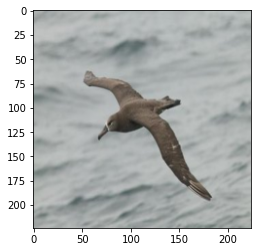

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', combined_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))  # Change the order of the axes

img, label = combined_dataset[0]
show_example(img, label)

## Split Training Dataset into train and validation

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch

def get_combined_indices(combined_dataset, is_training_image):
    train_indices, test_indices = [], []
    offset = 0  # Offset to account for different datasets in ConcatDataset
    for dataset in combined_dataset.datasets:
        for i, (img, _) in enumerate(dataset.imgs):
            # Construct relative path as used in is_training_image
            rel_path = os.path.normpath(img).replace(os.sep, '/').replace('../', './').replace('./CUB_200_2011/images/', '')
            if rel_path in is_training_image:  # Check if the image is in the dictionary
                if is_training_image[rel_path] == 1:
                    train_indices.append(i + offset)  # Image is for training
                else:
                    test_indices.append(i + offset)  # Image is for testing
        offset += len(dataset)  # Update offset for the next dataset
        print(f"Offset: {offset}, Train indices: {len(train_indices)}, Test indices: {len(test_indices)}")
    return train_indices, test_indices

def get_labels_for_indices(dataset, indices):
    # Concatenate the targets of all constituent datasets
    targets = torch.cat([torch.tensor(d.targets) for d in dataset.datasets])
    # Get the targets for the given indices
    labels = targets[indices]
    return labels

if not os.path.exists('train_indices.npy'):
    # Get combined train and test indices
    train_indices, other_indices = get_combined_indices(combined_dataset, is_training_image)
    test_indices, val_indices = train_test_split(other_indices, test_size=0.2, random_state=42)
    print(f"Number of training indices: {len(train_indices)}")
    print(f"Number of testing indices: {len(test_indices)}")
    print(f"Number of testing indices: {len(val_indices)}")

    # Save the indices to .npy files
    np.save('train_indices.npy', train_indices)
    np.save('test_indices.npy', test_indices)
    np.save('val_indices.npy', val_indices)
else:
    print("indices exist, loading them...")

# Load indices from .npy files (demonstration)
train_indices = np.load('train_indices.npy')
val_indices = np.load('val_indices.npy')
test_indices = np.load('test_indices.npy')

# Create subset datasets
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)
test_dataset = Subset(combined_dataset, test_indices)

# Create the data loader for training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create the data loaders for validation and test
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training set size: ", len(train_dataset))
print("Validation set size: ", len(val_dataset))
print("Test set size: ", len(test_dataset))

indices exist, loading them...
Training set size:  23976
Validation set size:  1159
Test set size:  4635


In [4]:
import torch
print(torch.__version__)
def get_class_distribution(dataset, indices):
    # Concatenate the targets of all constituent datasets
    targets = torch.cat([torch.tensor(d.targets) for d in dataset.datasets])
    # Get the targets for the given indices
    targets = targets[indices]
    # Count the number of occurrences of each class
    count_dict = {k: 0 for k in range(len(np.unique(targets)))}
    for target in targets:
        count_dict[int(target)] += 1
    return count_dict

# Get class distribution for train, test and validation sets
train_class_distribution = get_class_distribution(combined_dataset, train_indices)
val_class_distribution = get_class_distribution(combined_dataset, val_indices)
test_class_distribution = get_class_distribution(combined_dataset, test_indices)

print("Training set class distribution: ", train_class_distribution)
print("Validation set class distribution: ", val_class_distribution)
print("Test set class distribution: ", test_class_distribution)
print("train class length: ", len(train_class_distribution))
print("val class length: ", len(val_class_distribution))
print("test class length: ", len(test_class_distribution))

2.2.2+cu118
Training set class distribution:  {0: 120, 1: 120, 2: 120, 3: 120, 4: 120, 5: 120, 6: 120, 7: 120, 8: 120, 9: 120, 10: 120, 11: 120, 12: 120, 13: 120, 14: 120, 15: 120, 16: 120, 17: 120, 18: 120, 19: 120, 20: 120, 21: 120, 22: 120, 23: 120, 24: 120, 25: 120, 26: 120, 27: 120, 28: 120, 29: 120, 30: 120, 31: 120, 32: 120, 33: 120, 34: 120, 35: 120, 36: 120, 37: 120, 38: 120, 39: 120, 40: 120, 41: 120, 42: 120, 43: 120, 44: 120, 45: 120, 46: 120, 47: 120, 48: 120, 49: 120, 50: 120, 51: 120, 52: 120, 53: 120, 54: 120, 55: 120, 56: 120, 57: 120, 58: 120, 59: 120, 60: 120, 61: 120, 62: 120, 63: 120, 64: 120, 65: 120, 66: 120, 67: 120, 68: 120, 69: 120, 70: 120, 71: 120, 72: 120, 73: 120, 74: 120, 75: 120, 76: 120, 77: 120, 78: 120, 79: 120, 80: 120, 81: 120, 82: 120, 83: 120, 84: 120, 85: 120, 86: 120, 87: 120, 88: 120, 89: 120, 90: 120, 91: 120, 92: 120, 93: 120, 94: 120, 95: 120, 96: 120, 97: 120, 98: 120, 99: 120, 100: 120, 101: 120, 102: 120, 103: 120, 104: 120, 105: 120, 106

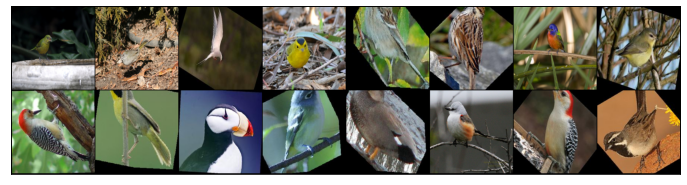

In [5]:
import torchvision.utils as vutils

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(vutils.make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

## EfficientNetB0 Transfer Learning Model Creation

In [6]:
import torch
from torch import nn
from torchvision.models import efficientnet_b0
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def training_step(self, batch):
        raise NotImplementedError

    def validation_step(self, batch):
        raise NotImplementedError

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

class EfficientNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = efficientnet_b0(pretrained=True)

        # Add custom layers
        self.network.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )


    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def freeze(self):
        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last layers
        for param in list(self.network.parameters())[0:-4]:
            param.requires_grad = True

    def unfreeze(self):
        # Unfreeze all parameters of the model
        for param in self.network.parameters():
            param.requires_grad = True

## Training the Model

In [7]:
import numpy as np
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
num_classes = len(combined_dataset.classes)
model = EfficientNetModel(num_classes).to(device)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

def fit(epochs, lr, train_loader, val_loader, optimizer, weight_decay=0):
    optimizer = optimizer(model.parameters(), lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        print("Starting epoch ", epoch+1, " of ", epochs)
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch = (inputs, labels)
            # Compute predictions and losses
            outputs = model(inputs)
            loss = model.training_step(batch)
            train_losses.append(loss.item())
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            acc = torch.sum(preds == labels.data) / len(labels)
            train_accs.append(acc.item())
            # Backpropagation
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 1)
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        # Record training loss and accuracy
        history['train_loss'].append(np.mean(train_losses))
        history['train_acc'].append(np.mean(train_accs))

        # Validation phase
        model.eval()
        val_losses = []
        val_accs = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                batch = (inputs, labels)
                # Compute predictions and losses
                loss = model.validation_step(batch)['val_loss']
                val_losses.append(loss.item())
                # Compute accuracy
                acc = model.validation_step(batch)['val_acc']
                val_accs.append(acc.item())
        # Record validation loss and accuracy
        history['val_loss'].append(np.mean(val_losses))
        history['val_acc'].append(np.mean(val_accs))
        print(f'Epoch {epoch+1}/{epochs}, train loss: {np.mean(train_losses):.4f}, val loss: {np.mean(val_losses):.4f}, val loss: {np.mean(val_losses):.4f}, train acc: {np.mean(train_accs):.4f}, val acc: {np.mean(val_accs):.4f}')
    return history

True
Device:  cuda


c:\Users\wamik\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wamik\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
weight_decay = 1e-5
model.freeze()
history = fit(num_epochs, lr, train_loader, val_loader, opt_func)
#model.unfreeze()
#lr = 0.0001
#new_history = fit(num_epochs, lr, train_loader, val_loader, opt_func)
# Append new history to existing history
#for key in history.keys():
#    history[key].extend(new_history[key])

Starting epoch  1  of  30


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig('efficientnet_train_val_acc_loss.png')

plot_history(history)

## Test the Model

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

test_model(model, test_loader, device)

## Save the Model

In [ ]:
# Save the trained model
torch.save(model, 'efficientnet_b0.pth')